In [13]:
import os 
import json
from pathlib import Path
from typing import List, Tuple
import numpy as np
import torch
from torch import nn


root = Path.cwd().parent
data = root / "data" / "processed"/"train_x.pt"
labels = root / "data" / "processed"/"train_y.pt"
x_train = torch.load(data)
y_train = torch.load(labels)

In [6]:
from call_of_birds_autobird.model import CNNTransformer
model = CNNTransformer(n_classes=10)
y_pred = model(x_train)
print(y_pred.shape)

torch.Size([1728, 10])


In [15]:
print(f"Loaded training data shape: {x_train.shape}")
print(f"Loaded training labels shape: {y_train.shape}")
print(f"Unique training labels: {torch.unique(y_train)}")
print(f"Model output shape: {y_pred.shape}")
print(f"Number of model parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Model architecture:\n{model}")
print("Test complete.")

Loaded training data shape: torch.Size([1728, 1, 64, 157])
Loaded training labels shape: torch.Size([1728])
Unique training labels: tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  69,  70,
         71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
         85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  96,  97,  98,  99,
        100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113])
Model output shape: torch.Size([1728, 10])
Number of model parameters: 1214474
Model architecture:
CNNTransformer(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2

In [32]:
print(x_train.shape, x_train.dtype)
print("min/max:", x_train.min().item(), x_train.max().item())
print("mean/std:", x_train.mean().item(), x_train.std().item())


torch.Size([1728, 1, 64, 157]) torch.float32
min/max: -2.066397190093994 4.7909369468688965
mean/std: 1.8662483114439965e-08 1.0


In [35]:

import os 
import json
from pathlib import Path
from typing import List, Tuple
import numpy as np
import torch
from torch import nn


root = Path.cwd().parent
data = root / "data" / "processed"/"train_x.pt"
labels = root / "data" / "processed"/"train_y.pt"
x_train = torch.load(data)
y_train = torch.load(labels)

# Remap labels to consecutive class indices starting at 0
unique_labels, inverse_indices = torch.unique(y_train, return_inverse=True)
y_train = inverse_indices.long()
num_classes = int(unique_labels.numel())

def train(lr: float = 1e-3, epochs: int = 5, batch_size: int = 32):
    model = CNNTransformer(n_classes=num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    dataset = torch.utils.data.TensorDataset(x_train, y_train)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in dataloader:
            optimizer.zero_grad()
            logits = model(inputs)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * inputs.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss /= total
        acc = correct / total
        print(f"Epoch {epoch+1}/{epochs} | loss={epoch_loss:.4f} | acc={acc:.4f}")

    return model


In [33]:
N = len(x_train)
perm = torch.randperm(N)
split = int(0.9 * N)
tr_idx, va_idx = perm[:split], perm[split:]

train_ds = torch.utils.data.TensorDataset(x_train[tr_idx], y_train[tr_idx])
val_ds   = torch.utils.data.TensorDataset(x_train[va_idx], y_train[va_idx])

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl   = torch.utils.data.DataLoader(val_ds, batch_size=32, shuffle=False)

def eval_acc(model, dl):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in dl:
            pred = model(xb).argmax(1)
            correct += (pred == yb).sum().item()
            total += yb.size(0)
    return correct / total


In [34]:
eval_acc(model, val_dl)

0.005780346820809248

In [36]:
train(lr=0.001, epochs=5, batch_size=32)
probs = torch.softmax(y_pred, dim=1)
print(probs[0], probs[0].sum())
print(f"argmax: {torch.argmax(probs[0])}")
print(f"true label: {y_train[0]}")
print("Training complete.")

Epoch 1/5 | loss=4.6335 | acc=0.0208
Epoch 2/5 | loss=4.4516 | acc=0.0266
Epoch 3/5 | loss=4.4098 | acc=0.0301
Epoch 4/5 | loss=4.3634 | acc=0.0365
Epoch 5/5 | loss=4.2711 | acc=0.0382
tensor([0.0022, 0.0208, 0.0033, 0.0085, 0.0059, 0.0109, 0.0065, 0.0048, 0.0121,
        0.0046, 0.0137, 0.0072, 0.0118, 0.0098, 0.0132, 0.0038, 0.0067, 0.0048,
        0.0094, 0.0134, 0.0140, 0.0222, 0.0121, 0.0120, 0.0053, 0.0056, 0.0054,
        0.0068, 0.0054, 0.0204, 0.0175, 0.0130, 0.0089, 0.0139, 0.0105, 0.0049,
        0.0110, 0.0055, 0.0052, 0.0066, 0.0097, 0.0034, 0.0054, 0.0058, 0.0146,
        0.0041, 0.0052, 0.0040, 0.0103, 0.0217, 0.0033, 0.0052, 0.0109, 0.0032,
        0.0138, 0.0137, 0.0036, 0.0251, 0.0083, 0.0110, 0.0143, 0.0041, 0.0106,
        0.0051, 0.0067, 0.0041, 0.0053, 0.0062, 0.0098, 0.0270, 0.0052, 0.0049,
        0.0088, 0.0115, 0.0080, 0.0046, 0.0041, 0.0076, 0.0043, 0.0057, 0.0133,
        0.0189, 0.0036, 0.0119, 0.0077, 0.0050, 0.0057, 0.0049, 0.0080, 0.0068,
        0.0055,

In [37]:
small_x = x_train[:64].clone()
small_y = y_train[:64].clone()

def overfit_test():
    model = CNNTransformer(n_classes=num_classes)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    dl = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(small_x, small_y),
        batch_size=16,
        shuffle=True
    )

    for epoch in range(50):
        model.train()
        correct = 0
        total = 0
        loss_sum = 0.0
        for xb, yb in dl:
            opt.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            opt.step()
            loss_sum += loss.item() * xb.size(0)
            correct += (logits.argmax(1) == yb).sum().item()
            total += yb.size(0)

        print(f"{epoch:02d} loss={loss_sum/total:.4f} acc={correct/total:.3f}")

overfit_test()


00 loss=4.8817 acc=0.000
01 loss=4.1668 acc=0.047
02 loss=3.9426 acc=0.062
03 loss=3.7385 acc=0.031
04 loss=3.5776 acc=0.078
05 loss=3.4776 acc=0.094
06 loss=3.3814 acc=0.094
07 loss=3.2749 acc=0.094
08 loss=3.1752 acc=0.109
09 loss=3.0854 acc=0.156
10 loss=2.9721 acc=0.172
11 loss=2.9050 acc=0.172
12 loss=2.7894 acc=0.203
13 loss=2.7467 acc=0.203
14 loss=2.6130 acc=0.219
15 loss=2.4804 acc=0.312
16 loss=2.3953 acc=0.422
17 loss=2.3385 acc=0.344
18 loss=2.2073 acc=0.359
19 loss=2.0755 acc=0.438
20 loss=1.9426 acc=0.453
21 loss=1.8566 acc=0.453
22 loss=1.7213 acc=0.516
23 loss=1.7485 acc=0.469
24 loss=1.5757 acc=0.578
25 loss=1.5291 acc=0.562
26 loss=1.5131 acc=0.531
27 loss=1.3966 acc=0.625
28 loss=1.3631 acc=0.562
29 loss=1.2173 acc=0.734
30 loss=1.1154 acc=0.734
31 loss=1.1725 acc=0.609
32 loss=1.1206 acc=0.625
33 loss=1.0647 acc=0.734
34 loss=1.0116 acc=0.703
35 loss=0.9027 acc=0.766
36 loss=0.9134 acc=0.812
37 loss=0.8719 acc=0.781
38 loss=0.9064 acc=0.703
39 loss=0.9026 acc=0.688


In [38]:
print("num_classes:", num_classes)
counts = torch.bincount(y_train)
print("min count:", int(counts.min()), "max count:", int(counts.max()))


num_classes: 112
min count: 1 max count: 30


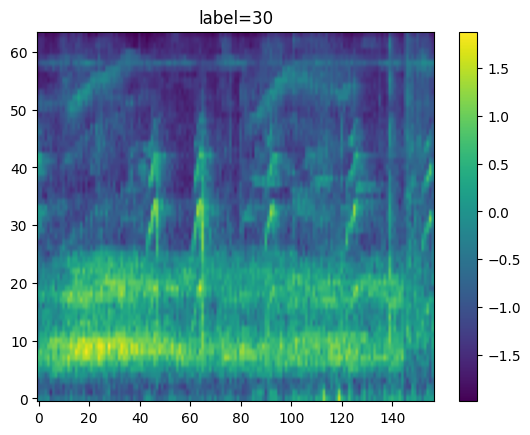

In [31]:
import matplotlib.pyplot as plt

m = x_train[0, 0].cpu().numpy()  # [mels, frames]
plt.imshow(m, aspect="auto", origin="lower")
plt.title(f"label={int(y_train[0])}")
plt.colorbar()
plt.show()


In [ ]:
idx = 0
x0 = x_train[idx:idx+1]
y0 = y_train[idx].item()

def track_single_example(model):
    model.eval()
    with torch.no_grad():
        logits = model(x0)
        probs = logits.softmax(dim=1).squeeze(0)
    return float(probs[y0]), int(probs.argmax().item())

# inside training loop, after each epoch:
# p_true, pred = track_single_example(model)
p_true, pred = track_single_example(model)
print(f"example0: p(true)={p_true:.4f}, pred={pred}, true={y0}")
